## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [2]:
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [76]:
ds = argo_loader.region([30,40,-55,-50, 200,2000]).to_xarray()

In [205]:
def get_ds_interp(ds,depth_min,depth_max,sample_rate):
    ds_prof=ds.argo.point2profile()
    median_dp=ds_prof.PRES.where(ds_prof.PRES<depth_max).where(depth_min<ds_prof.PRES).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_rate,drop=True).N_PROF
    ds_sel=ds_prof.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(0,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [206]:
CT_interp=get_ds_interp(ds,0,1000,3)

In [207]:
CT_interp

<xarray.DataArray 'TEMP' (N_PROF: 405, PRES_INTERPOLATED: 500)>
array([[2.927    , 2.927    , 2.927    , ..., 2.5010588, 2.50002  ,
        2.498    ],
       [0.762    , 0.762    , 0.762    , ..., 1.8459799, 1.84514  ,
        1.8523135],
       [1.3778   , 1.3778   , 1.3778   , ..., 1.3396549, 1.3380885,
        1.3367451],
       ...,
       [2.029    , 2.029    , 2.029    , ..., 2.194059 , 2.197    ,
        2.196961 ],
       [1.315    , 1.315    , 1.315    , ..., 2.174    , 2.173    ,
        2.173    ],
       [1.506    , 1.506    , 1.506    , ..., 2.215    , 2.21398  ,
        2.2129805]], dtype=float32)
Coordinates:
  * N_PROF             (N_PROF) int64 592 594 595 596 ... 2079 2080 2081 2082
    LATITUDE           (N_PROF) float64 -50.34 -53.22 -54.97 ... -52.53 -51.23
    LONGITUDE          (N_PROF) float64 37.57 30.12 30.73 ... 37.91 37.49 37.6
    TIME               (N_PROF) datetime64[ns] 2017-01-14T13:25:03 ... 2022-0...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 8 ... 992 994 996 998
Attributes:
    casted:   1

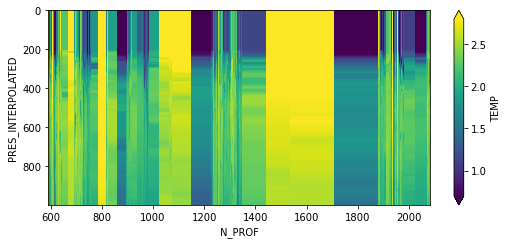

In [208]:
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [209]:
def get_ds_filt(ds,first,last,step):
    quant=int((last-first)/step)+1
    temp=np.zeros((ds.N_PROF.shape[0],ds.PRES_INTERPOLATED.shape[0],quant))
    filter_scales=np.zeros((quant))

    for n,sig in enumerate(range(first,last+1,step)):
        sigma=sig/4/np.sqrt(12)
        temp[:,:,n]=filter.gaussian_filter1d(ds,sigma=sigma,mode='nearest')
        filter_scales[n]=sig
    
    CT_filt=xr.DataArray(temp, dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
            coords={'N_PROF':ds.N_PROF,'PRES_INTERPOLATED':ds.PRES_INTERPOLATED,'FILT_SCALE':filter_scales})
    
    return CT_filt

In [210]:
CT_filt=get_ds_filt(CT_interp,10,300,5)

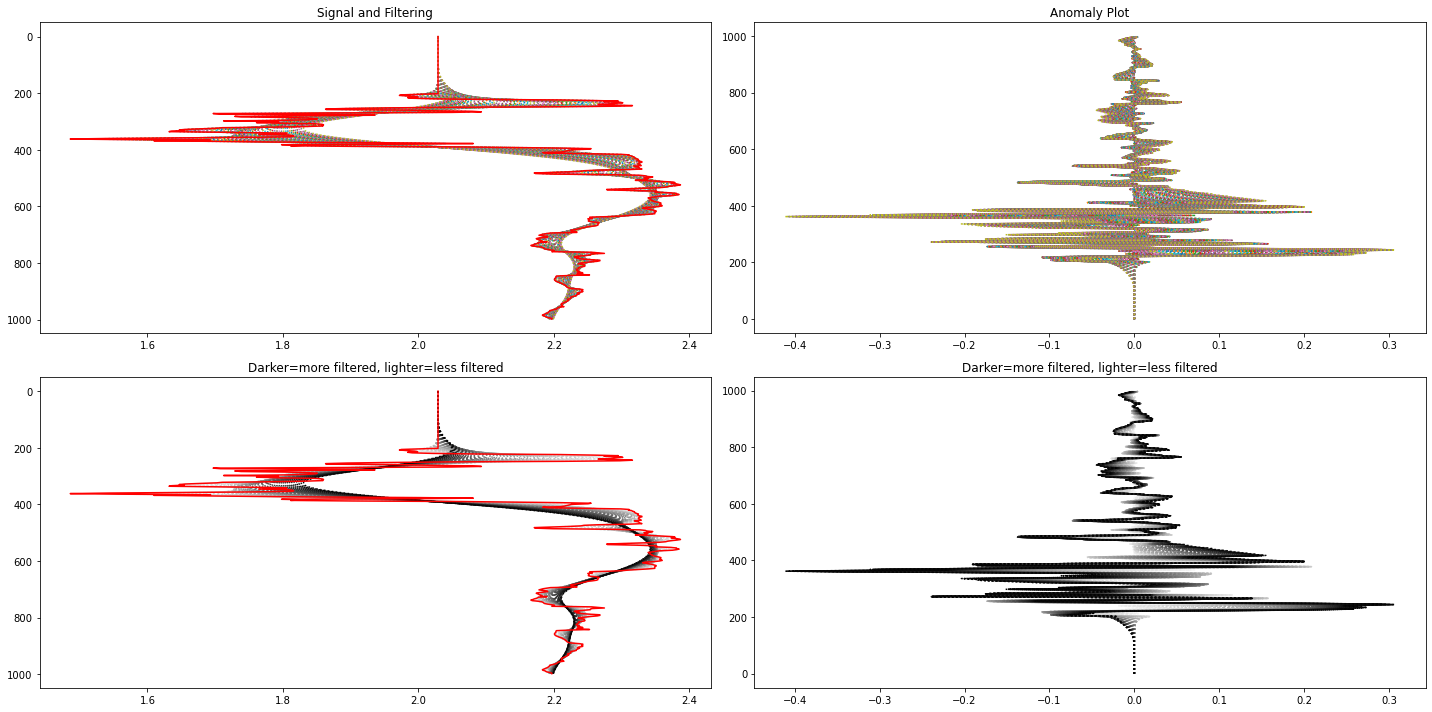

In [211]:
plt.figure(figsize=(20,10))
color=np.arange(0.01,1.01,1/quant)
color=np.flip(color,0)
prof_num=2080
prof=CT_interp.sel(N_PROF=prof_num)

plt.subplot(2,2,1)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.title("Darker=more filtered, lighter=less filtered")

for n,sigma in enumerate(range(first, last+1, step)):
    filt=CT_filt.sel(N_PROF=prof_num,FILT_SCALE=sigma)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))

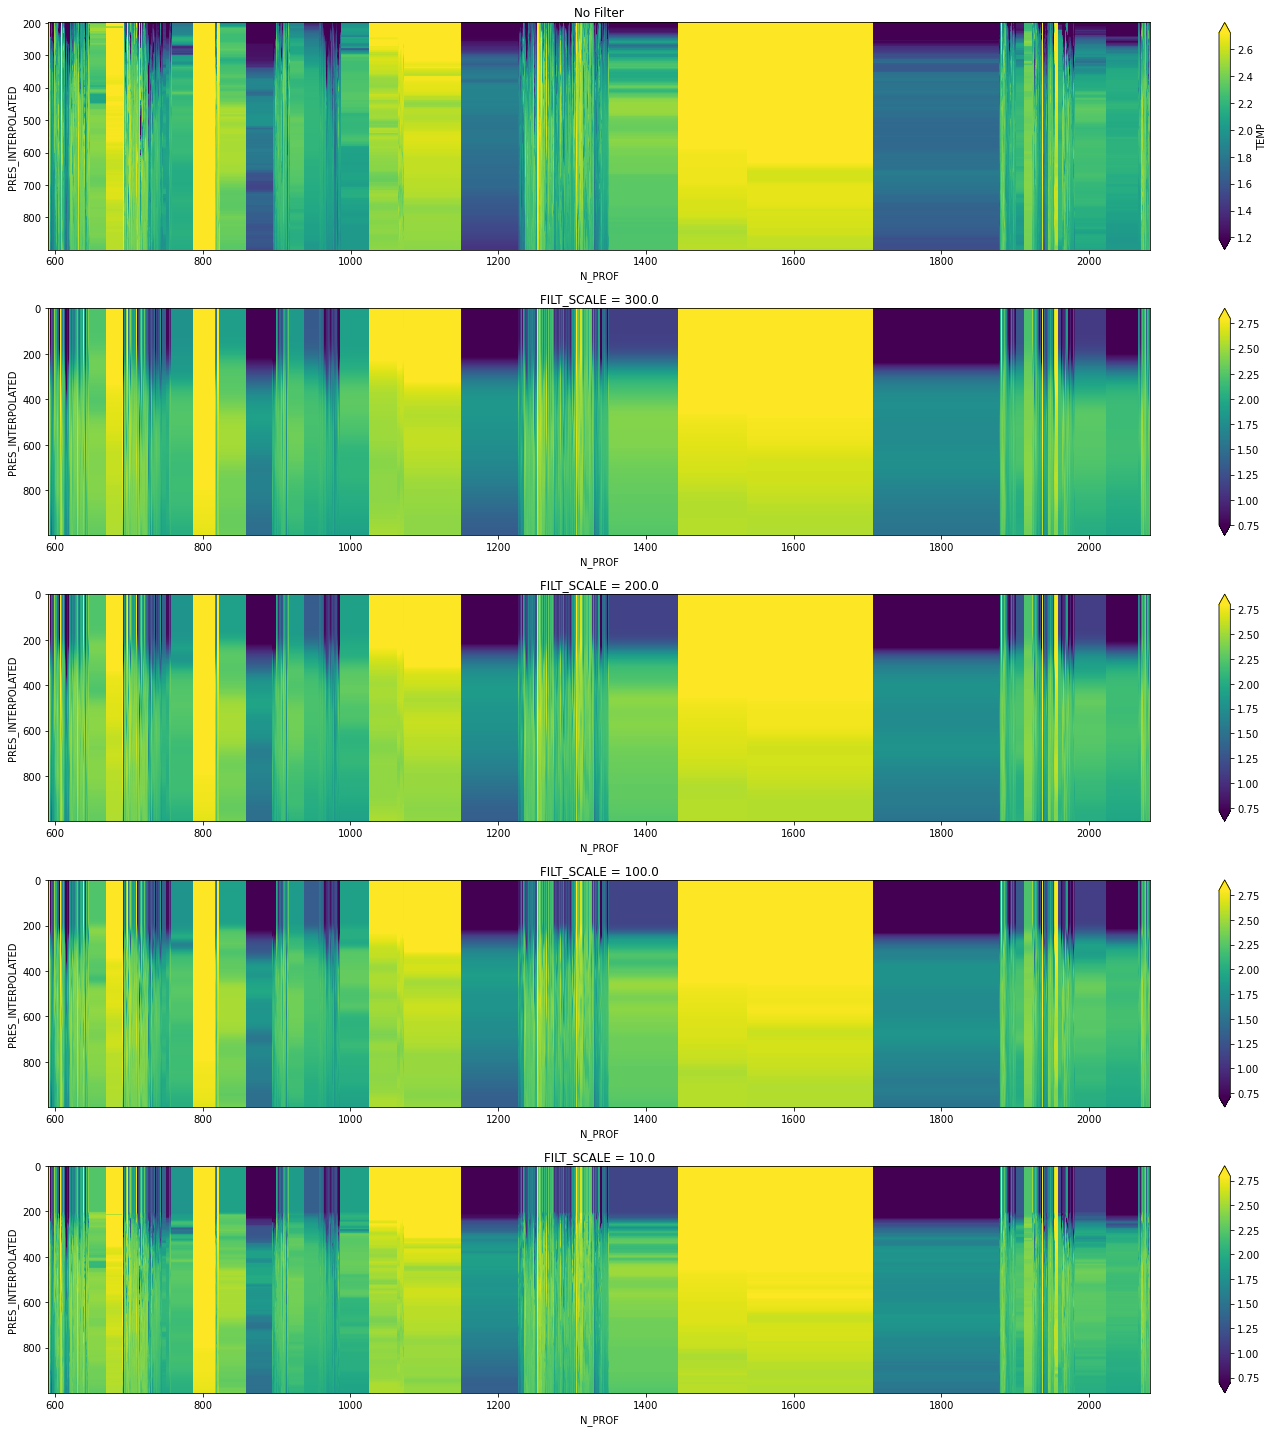

In [212]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT.plot(y='PRES_INTERPOLATED',robust=True)
plt.title("No Filter")
plt.gca().invert_yaxis()

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(FILT_SCALE=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

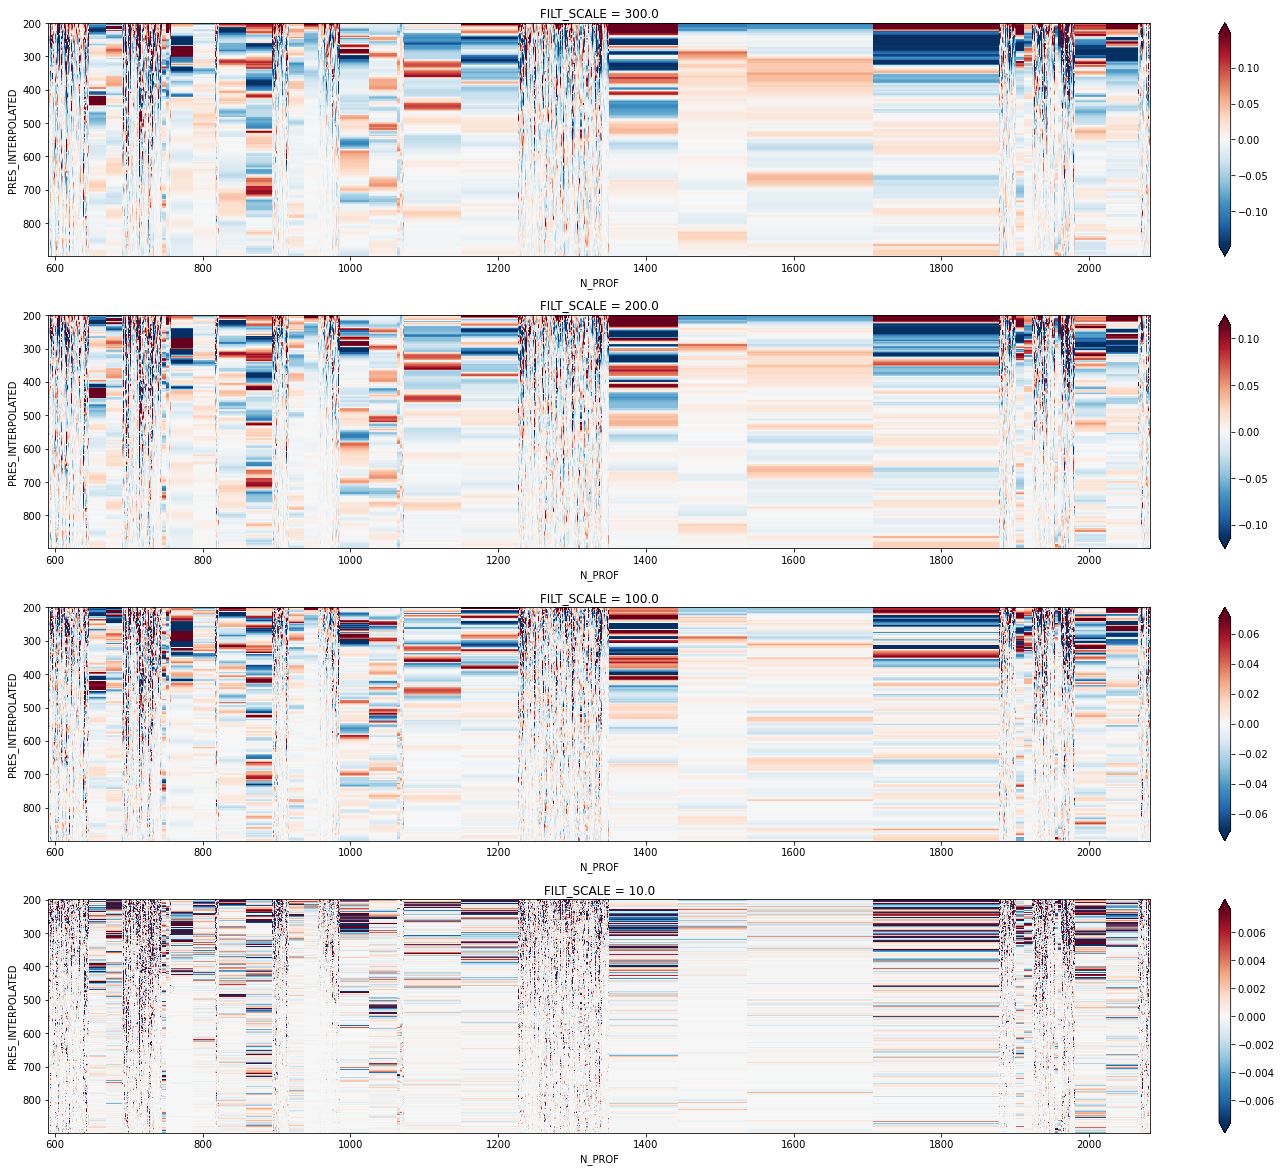

In [213]:
plt.figure(figsize=(20,20))

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(FILT_SCALE=sig)
    anom=filt-CT
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [214]:
var_scale=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    prof=CT_filt.sel(FILT_SCALE=sigma)
    var_scale[n]=(prof-CT).var()

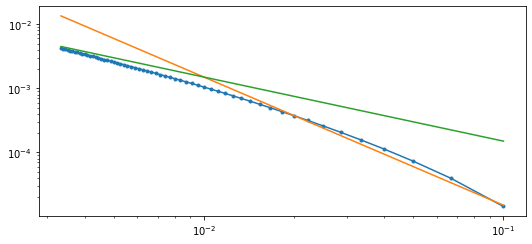

In [215]:
plt.plot(1/CT_filt.FILT_SCALE,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.FILT_SCALE
y_2=1.5*10**-7*x**-2
y_1=1.5*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

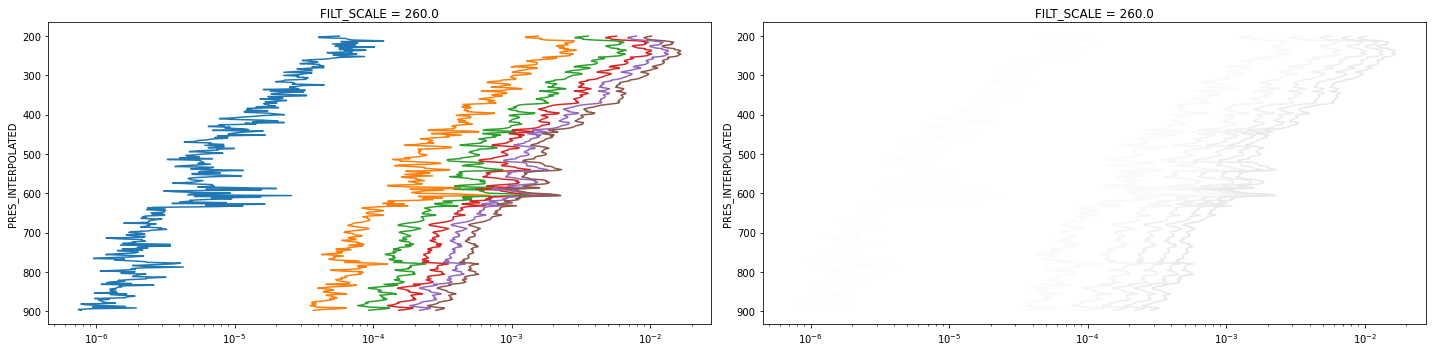

In [216]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')

for n,sig in enumerate(range(first,last+1,step*10)):
    prof=CT_filt.sel(FILT_SCALE=sig)
    
    plt.subplot(1,2,1)
    (prof-CT).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig)
    
    plt.subplot(1,2,2)
    (prof-CT).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sigma,color=str(color[n]))

In [218]:
interp_1000_3=get_ds_interp(ds,0,1000,3)
interp_2000_3=get_ds_interp(ds,1000,2000,3)
interp_1000_12=get_ds_interp(ds,0,1000,12)
interp_2000_12=get_ds_interp(ds,1000,2000,12)

In [219]:
filt_1000_3=get_ds_filt(interp_1000_3,10,300,5)
filt_2000_3=get_ds_filt(interp_2000_3,10,300,5)
filt_1000_12=get_ds_filt(interp_1000_12,10,300,5)
filt_2000_12=get_ds_filt(interp_2000_12,10,300,5)

In [220]:
var_1000_3=np.zeros(quant)
var_2000_3=np.zeros(quant)
var_1000_12=np.zeros(quant)
var_2000_12=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    prof_1000_3=filt_1000_3.sel(FILT_SCALE=sigma)
    var_1000_3[n]=(prof_1000_3-CT).var()
    
    prof_2000_3=filt_2000_3.sel(FILT_SCALE=sigma)
    var_2000_3[n]=(prof_2000_3-CT).var()
    
    prof_1000_12=filt_1000_12.sel(FILT_SCALE=sigma)
    var_1000_12[n]=(prof_1000_12-CT).var()
    
    prof_2000_12=filt_2000_12.sel(FILT_SCALE=sigma)
    var_2000_12[n]=(prof_2000_12-CT).var()

Text(0.5, 1.0, 'depth: [1000,2000], sample scale: 12m, profiles: 126')

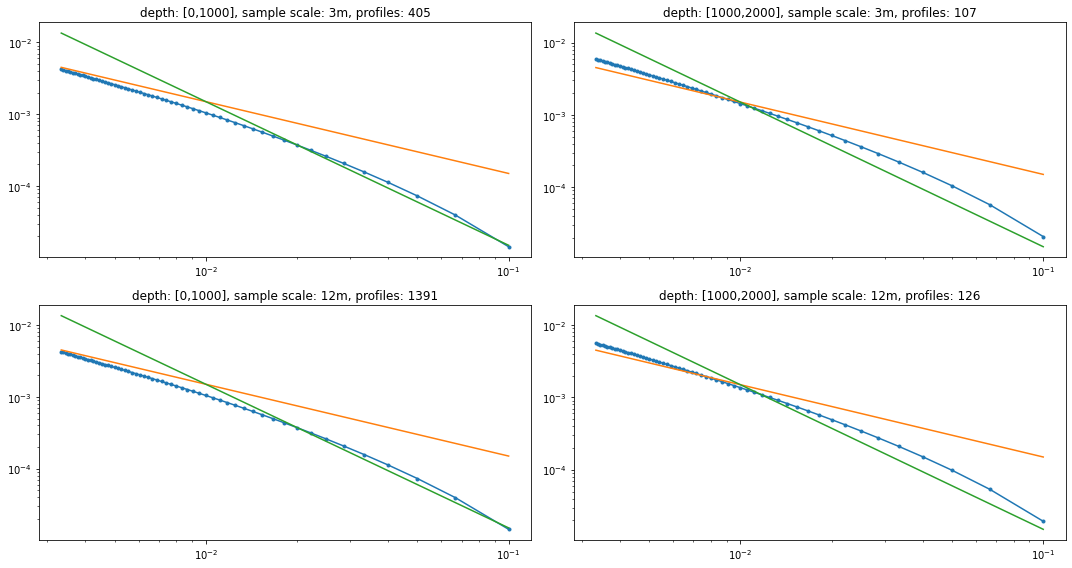

In [222]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(1/filt_1000_3.FILT_SCALE,var_1000_3,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/filt_1000_3.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.title("depth: [0,1000], sample scale: 3m, profiles: {}".format(interp_1000_3.N_PROF.shape[0]))

plt.subplot(2,2,2)
plt.plot(1/filt_2000_3.FILT_SCALE,var_2000_3,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/filt_2000_3.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.title("depth: [1000,2000], sample scale: 3m, profiles: {}".format(interp_2000_3.N_PROF.shape[0]))

plt.subplot(2,2,3)
plt.plot(1/filt_1000_12.FILT_SCALE,var_1000_12,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/filt_1000_12.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.title("depth: [0,1000], sample scale: 12m, profiles: {}".format(interp_1000_12.N_PROF.shape[0]))

plt.subplot(2,2,4)
plt.plot(1/filt_2000_12.FILT_SCALE,var_2000_12,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/filt_2000_12.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.title("depth: [1000,2000], sample scale: 12m, profiles: {}".format(interp_2000_12.N_PROF.shape[0]))